# Chapter 1: Basics of geological modeling with GemPy
***
In this first chapter, we will guide through the most important steps of modeling with GemPy on the base of a relatively simple geological model, while introducing essential objects and functions. We will illustrate how to:
- import and create input data for modeling in GemPy
- return and visualize input data
- generate a 3D geological model in GemPy
- visualize a model directly in GemPy
***

## The example model: Simple stratigraphy and one fault

Our synthetic example model is defined to be cubic, with an extent of 2000 m in every direction of the 3D space. Lithologically, it includes five stratigraphic units of sedimentary origin. Here, we list them from top (youngest) to bottom (oldest):

- Sandstone (2)
- Siltstone
- Shale
- Sandstone (1)
- Basement (undefined, default by GemPy)

We assume that these were simply deposited in consequential order and deformed (tilted and folded) afterwards. Additionally, they are displaced by a continuous normal fault.
The final modeling results should look somewhat like this, depending on the type of visualization:

![2D and 3D visualizations of our example model.](../../docs/readme_images/model_example_duo.png "2D and 3D visualizations of our example model")

As this example involves a simple sequence of layers and only one fault, it provides an adequate level of complexity to introduce the basics of modeling with GemPy. At the end of this chapter, we will show some model variations and how the modeling workflow has to be adapted accordingly.

## Preparing the Python environment

For modeling with GemPy, we first need to import it. We should also import any other packages we want to utilize in our Python environment.Typically, we will also require `NumPy` and `Matplotlib` when working with GemPy. At this point, we can further customize some settings as desired, e.g. the size of figures or, as we do here, the way that `Matplotlib` figures are displayed in our notebook (`%matplotlib inline`).

In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Importing and creating a set of input data

The data used for the construction of a model in GemPy is stored in Python objects. The main data classes are:

    -  Interfaces
    -  Orientations
    -  Grid
    -  Formations
    -  Series
    -  Additional data
    -  Faults
    
We will see each of this class in further detail in the future.

GemPy uses  Python [pickle] for fast storing of objects (https://docs.python.org/3/library/pickle.html). However, module version consistency is required. For loading a pickle into GemPy, you have to make sure that you are using the same version of pickle and dependent modules (e.g.: `Pandas`, `NumPy`) as were used when the data was originally stored.

Most of data can also be generated from raw data that comes in the form of CSV-files (CSV = comma-separated values). Such files might be attained by exporting model data from a different program such as GeoModeller or by simply creating it in spreadsheet software such as Microsoft Excel or LibreOffice Calc.

In this tutorial, all input data is created by importing such CSV-files. These exemplary files can be found in the `input_data` folder in the root folder of GemPy. 
The data comprises $x$-, $y$- and $z$-positional values for all surface points and orientation measurements. For the latter, poles, azimuth and polarity are additionally included. Surface points are furthermore assigned a formation. This might be a lithological unit such as "Sandstone" or a structural feature such as "Main Fault". It is decisive to remember that, in GemPy, interface position points mark the **bottom** of a layer. If such points are needed to resemble a top of a formation (e.g. when modeling an intrusion), this can be achieved by defining a respectively inverted orientation measurement.

As we generate our `Data` from CSV-files, we also have to define our model's real extent in $x$, $y$ and $z$, as well as declare a desired resolution for each axis. This resolution will in turn determine the number of voxels used during modeling. Here, we rely on a medium resolution of 50x50x50, amounting to 125,000 voxels. The model extent should be chosen in a way that it contains all relevant data in a representative space. As our model voxels are not cubes, but prisms, the resolution can take a different shape than the extent. We don't recommend going much higher than 100 cells in every direction (1,000,000 voxels), as higher resolutions will become increasingly difficult to compute.

In [2]:
geo_model = gp.create_model('Model_Tuto1-1')

In [3]:
# Importing the data from CSV-files and setting extent and resolution
gp.init_data(geo_model, [0,2000.,0,2000.,0,2000.],[50,50,50], 
      path_o = os.pardir+"/input_data/tut_chapter1/simple_fault_model_orientations.csv",
      path_i = os.pardir+"/input_data/tut_chapter1/simple_fault_model_points.csv", default_values=True); 

The input data can then be listed using the command `get_data`. Note that the order of formations and respective allocation to series is still completely arbitrary. We will fix this in the following.

In [4]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
0,800,50,750,0.486942,0.250100,0.460626,Shale,Default series,NaN,1
1,800,150,700,0.486942,0.276416,0.447468,Shale,Default series,NaN,1
2,800,300,700,0.486942,0.315889,0.447468,Shale,Default series,NaN,1
3,800,500,800,0.486942,0.368521,0.473784,Shale,Default series,NaN,1
4,800,1000,1000,0.486942,0.500100,0.526416,Shale,Default series,NaN,1


In [5]:
gp.get_data(geo_model, 'orientations').head()

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series
0,1000,1000,950.000,0.539574,0.5001,0.513258,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Default series,NaN,1
1,400,1000,1400.000,0.381679,0.5001,0.631679,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Default series,NaN,1
2,500,1000,864.602,0.407995,0.5001,0.490785,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Default series,NaN,1


## Declaring the sequential order of geological formations

We want our geological units to appear in the correct order relative to age. Such order might for example be given by a depositional sequence of stratigraphy, unconformities due to erosion or other lithological genesis events such as igneous intrusions. A similar age-related order is to be declared for the faults in our model.
In GemPy, the function *set_series* is used to assign formations to different sequential series via declaration in a Python dictionary.

Defining the correct order of series is vital to the construction of the model! If you are using Python 3.6, the age-related order will already be defined by the order of key entries, i.e. the first entry is the youngest series, the last one the oldest. For older versions of Python, you will have to specify the correct order as a separate list attribute "*order_series*" (see cell below).

You can assign several formations to one series. The order of the units within such as series is only relevant for the color code, thus we recommend to be consistent. You can define this order via another attribute "*order_formations*" or by using the specific command *set_order_formations*. (If the order of the pile differs from the final result the color of the interfaces and input data will be different. ?)

Every fault is treated as an independent series and have to be at set at the **top of the pile**. The relative order between the distinct faults defines the tectonic relation between them (first entry is the youngest).

In a model with simple sequential stratigraphy, all layer formations can be assigned to one single series without a problem. All unit boundaries and their order would then be given by interface points. However, to model more complex lithostratigraphical relations and interactions, the definition of separate series becomes important. For example, you would need to declare a "newer" series to model an unconformity or an intrusion that disturbs older stratigraphy.

By default we create a simple sequence infered by the data:

In [6]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,Shale,Default series,1,False,#015482,1
1,Sandstone_1,Default series,2,False,#9f0052,2
2,Siltstone,Default series,3,False,#ffbe00,3
3,Sandstone_2,Default series,4,False,#728f02,4
4,Main_Fault,Default series,5,False,#443988,5
5,basement,Default series,6,True,#ff3f20,6


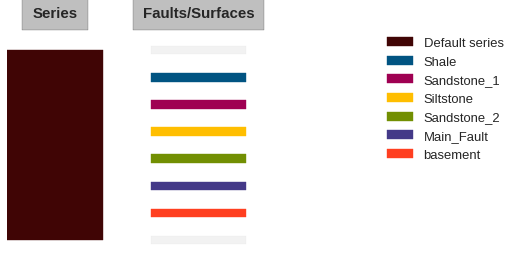

In [7]:
gp.get_sequential_pile(geo_model)

Our example model comprises four main layers (plus an underlying basement that is automatically generated by GemPy) and one main normal fault displacing those layers. Assuming a simple stratigraphy where each younger unit was deposited onto the underlying older one, we can assign these layer formations to one series called "Strat_Series". For the fault, we declare a respective "Fault_Series" as the first key entry in the `set_series` dictionary. We could give any other names to these series, the formations however have to be referred to as named in the input data.

In [8]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
0,Shale,Default series,1,False,#015482,1
1,Sandstone_1,Default series,2,False,#9f0052,2
2,Siltstone,Default series,3,False,#ffbe00,3
3,Sandstone_2,Default series,4,False,#728f02,4
4,Main_Fault,Default series,5,False,#443988,5
5,basement,Default series,6,True,#ff3f20,6


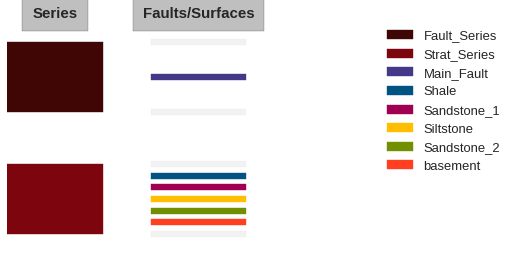

In [9]:
gp.map_series_to_surfaces(geo_model,
                            {"Fault_Series":'Main_Fault', 
                             "Strat_Series": ('Sandstone_2','Siltstone',
                                              'Shale', 'Sandstone_1', 'basement')}, remove_unused_series=True)

In [10]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#443988,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Strat_Series,5,True,#ff3f20,6


In [11]:
geo_model.series

,order_series,BottomRelation
Fault_Series,1,Erosion
Strat_Series,2,Erosion


In [12]:
geo_model.set_is_fault(['Fault_Series'])

Fault colors changed. If you do not like this behavior, set change_color to False.


,isFault,isFinite
Fault_Series,True,False
Strat_Series,False,False


In [13]:
geo_model.faults.faults_relations_df

,Fault_Series,Strat_Series
Fault_Series,False,False
Strat_Series,False,False


The sequence of geoligical series and assigned formations can be visualized using the function `get_sequential_pile`. Using a backend such as `%matplotlib notebook` or `%matplotlib qt5`, the figure generated by this function becomes interactive, i.e. you can change the order of series and formations by hand (via `%matplotlib inline`, the figure remains static). You can also re-assign a formation to a different series.

If the backend doen't seem to work properly right away, try executing the cell twice.

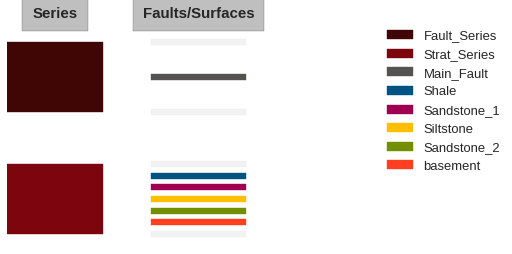

In [14]:
%matplotlib inline
gp.get_sequential_pile(geo_model)

Notice that the colors are order-dependent, i.e. they will remain in the same order every time the cell is executed, irrespective of re-assignment of formations. 
To make sure that every unit is in its right place, take a look at the legend on the right. If it doesn't show at first, try dragging the right edge to resize the figure. The legend will always show you the color currently assigned to a formation (in the future, every color will have the annotation within its rectangle to avoid confusion).

### Returning information from our input data

Our model input data, here named "*geo_model*", contains all the information that is essential for the construction of our model. You can access different types of information by using correspondent "*get*" functions.

We can, for example, return the coordinates of our modeling grid via *get_grid* and check its attribute values:

In [15]:
print(geo_model.grid)

Grid Object. Values: 
[[  20.   20.   20.]
 [  20.   20.   60.]
 [  20.   20.  100.]
 ...
 [1980. 1980. 1900.]
 [1980. 1980. 1940.]
 [1980. 1980. 1980.]]


As mentioned before, GemPy's core algorithm is based on interpolation of two types of data:
- interface (or surface) points
and
- orientation measurements

(if you want to know more on how this this interpolation algorithm works, checkout our chapter on the theory behind GemPy).

We introduced the function *get_data* above. You can also specify which kind of data you want to call, by declaring the string attribute "*dtype*" to be either "interfaces" (surface points) or "foliations" (orientation measurements). 

#### Interfaces Dataframe:

In [16]:
gp.get_data(geo_model, 'surface_points').head()

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
52,700,1000,900,0.460626,0.5001,0.500100,Main_Fault,Fault_Series,1,1
53,600,1000,600,0.434311,0.5001,0.421153,Main_Fault,Fault_Series,1,1
54,500,1000,300,0.407995,0.5001,0.342205,Main_Fault,Fault_Series,1,1
55,800,1000,1200,0.486942,0.5001,0.579047,Main_Fault,Fault_Series,1,1
56,900,1000,1500,0.513258,0.5001,0.657995,Main_Fault,Fault_Series,1,1


#### Foliations Dataframe:

In [17]:
gp.get_data(geo_model, 'orientations')

,X,Y,Z,X_r,Y_r,Z_r,G_x,G_y,G_z,dip,azimuth,polarity,surface,series,id,order_series
2,500,1000,864.602,0.407995,0.5001,0.490785,-0.948683,9.998257e-13,0.316229,71.565,270.0,1.0,Main_Fault,Fault_Series,1,1
0,1000,1000,950.000,0.539574,0.5001,0.513258,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Shale,Strat_Series,2,2
1,400,1000,1400.000,0.381679,0.5001,0.631679,0.316229,1.000019e-12,0.948683,18.435,90.0,1.0,Sandstone_2,Strat_Series,5,2


Notice that now all **formations** have been assigned to a **series** and are displayed in the correct order (from young to old).

### Visualizing input data

We can also visualize our input data. This might for example be useful to check if all points and measurements are defined the way we want them to. Using the function *plot_data*, we attain a 2D projection of our data points onto a plane of chosen *direction* (we can choose this attribute to be either $x$, $y$ or $z$). 

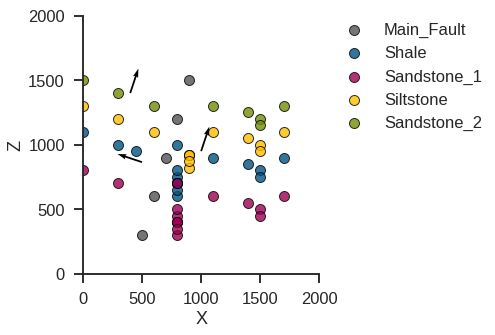

In [18]:
%matplotlib inline
gp.plot.plot_data(geo_model, direction='y')

In [19]:
geo_model.surfaces

,surface,series,order_surfaces,isBasement,color,id
4,Main_Fault,Fault_Series,1,False,#545352,1
0,Shale,Strat_Series,1,False,#015482,2
1,Sandstone_1,Strat_Series,2,False,#9f0052,3
2,Siltstone,Strat_Series,3,False,#ffbe00,4
3,Sandstone_2,Strat_Series,4,False,#728f02,5
5,basement,Strat_Series,5,True,#ff3f20,6


In [20]:
geo_model.surface_points

,X,Y,Z,X_r,Y_r,Z_r,surface,series,id,order_series
52,700,1000,900,0.460626,0.500100,0.500100,Main_Fault,Fault_Series,1,1
53,600,1000,600,0.434311,0.500100,0.421153,Main_Fault,Fault_Series,1,1
54,500,1000,300,0.407995,0.500100,0.342205,Main_Fault,Fault_Series,1,1
55,800,1000,1200,0.486942,0.500100,0.579047,Main_Fault,Fault_Series,1,1
56,900,1000,1500,0.513258,0.500100,0.657995,Main_Fault,Fault_Series,1,1
0,800,50,750,0.486942,0.250100,0.460626,Shale,Strat_Series,2,2
1,800,150,700,0.486942,0.276416,0.447468,Shale,Strat_Series,2,2
2,800,300,700,0.486942,0.315889,0.447468,Shale,Strat_Series,2,2
3,800,500,800,0.486942,0.368521,0.473784,Shale,Strat_Series,2,2
4,800,1000,1000,0.486942,0.500100,0.526416,Shale,Strat_Series,2,2


Using *plot_data_3D*, we can also visualize this data in 3D. Note that direct 3D visualization in GemPy requires [the Visualization Toolkit](https://www.vtk.org/) (VTK) to be installed.

All 3D VTK plots in GemPy are interactive. This means that we can drag and drop any data poit and measurement. The perpendicular axis views in VTK are particularly useful to move points solely on a desired 2D plane. Any changes will then be stored permanently in the "InputData" dataframe. If we want to reset our data points, we will then need to reload our original input data.

Executing the cell below will open a new window with a 3D interactive plot of our data.

In [21]:
gp.plot.plot_data_3D(geo_model);

closing vtk


### Model generation

Once we have made sure that we have defined all our primary information as desired in our object `DataManagement.InputData` (named `geo_data` in these tutorials), we can continue with the next step towards creating our geological model: preparing the input data for interpolation.

This is done by generating an `InterpolatorData` object (named `interp_data` in these tutorials) from our `InputData` object via the following function:

In [22]:
gp.set_interpolation_data(geo_model,
                          compile_theano=True,
                          theano_optimizer='fast_compile',
                          verbose=[])


Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


This function rescales the extent and coordinates of the original data (and store it in the attribute `geo_data_res` which behaves as a usual `InputData` object) and adds mathematical parameters that are needed for conducting the interpolation. The computation of this step may take a while, as it also compiles a theano function which is required for the model computation. However, should this not be needed, we can skip it by declaring `compile_theano = False` in the function.

Furthermore, this preparation process includes an assignment of numbers to each formation. Note that GemPy's always creates a default basement formation as the last formation number. Afterwards, numbers are allocated from youngest to oldest as defined by the sequence of series and formations. On the property `formations` on our interpolation data, we can find out which number has been assigned to which formation:

The parameters used for the interpolation can be returned using the function `get_kriging_parameters`. These are generated automatically from the orginal data, but can be changed if needed. However, users should be careful doing so, if they do not fully understand their significance.

In [23]:
gp.get_kriging_parameters(geo_model) # Maybe move this to an extra part?

AttributeError: module 'gempy' has no attribute 'get_kriging_parameters'

At this point, we have all we need to compute our full model via `compute_model`. By default, this will return two separate solutions in the form of arrays. The first gives information on the lithological formations, the second on the fault network in the model. These arrays consist of two subarrays as entries each:

1. Lithology block model solution:
    + Entry [0]: This array shows what kind of lithological formation is found in each voxel, as indicated by a respective formation_number.
    + Entry [1]: Potential field array that represents the orientation of lithological units and layers in the block model.
2. Fault network block model solution:
    + Entry [0]: Array in which all fault-separated areas of the model are represented by a distinct number contained in each voxel.
    + Entry [1}: Potential field array related to the fault network in the block model.
    
Below, we illustrate these different model solutions and how they can be used.

In [ ]:
geo_model.surface_points

In [ ]:
geo_model.additional_data

In [ ]:
geo_model.update_to_interpolator()

In [ ]:
geo_model.interpolator.print_theano_shared()

In [ ]:
geo_model.interpolator.set_initial_results()

In [ ]:
geo_model.interpolator.theano_graph.block_matrix.get_value().shape

In [25]:
geo_model.interpolator.len_series_i

array([ 4, 48])

In [24]:
sol = gp.compute_model(geo_model, compute_mesh=True)

ValueError: Input dimension mis-match. (input[0].shape[1] = 125104, input[1].shape[1] = 125000)
Apply node that caused the error: Elemwise{mul,no_inplace}(Subtensor{int64::, ::}.0, Elemwise{mul,no_inplace}.0)
Toposort index: 47
Inputs types: [TensorType(float64, matrix), TensorType(float64, matrix)]
Inputs shapes: [(0, 125104), (0, 125000)]
Inputs strides: [(8, 80), (1000000, 8)]
Inputs values: [array([], shape=(0, 125104), dtype=float64), array([], shape=(0, 125000), dtype=float64)]
Inputs type_num: [12, 12]
Outputs clients: [[Sum{axis=[0], acc_dtype=float64}(Elemwise{mul,no_inplace}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "../../gempy/core/theano/theano_graph_pro.py", line 276, in compute_series
    profile=False
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../gempy/core/theano/theano_graph_pro.py", line 1359, in compute_a_series
    Z_x = tif.ifelse(compute_scalar_ctr, self.compute_scalar_field(weights, self.grid_val_T),
  File "../../gempy/core/theano/theano_graph_pro.py", line 226, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val)
  File "../../gempy/core/theano/theano_graph_pro.py", line 1056, in scalar_field_at_all
    return_list=True)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../gempy/core/theano/theano_graph_pro.py", line 1021, in scalar_field_loop
    f_1 = self.contribution_faults(weights[:, a:b], a, b)
  File "../../gempy/core/theano/theano_graph_pro.py", line 1002, in contribution_faults
    weights[length_of_CG + length_of_CGI + length_of_U_I:, :] * fault_matrix_selection_non_zero, axis=0)

Debugprint of the apply node: 
Elemwise{mul,no_inplace} [id A] <TensorType(float64, matrix)> ''   
 |Subtensor{int64::, ::} [id B] <TensorType(float64, matrix)> ''   
 | |Subtensor{::, int64:int64:} [id C] <TensorType(float64, matrix)> ''   
 | | |<TensorType(float64, matrix)> [id D] <TensorType(float64, matrix)>
 | | |ScalarFromTensor [id E] <int64> ''   
 | | | |<TensorType(int64, scalar)> [id F] <TensorType(int64, scalar)>
 | | |ScalarFromTensor [id G] <int64> ''   
 | |   |<TensorType(int64, scalar)> [id H] <TensorType(int64, scalar)>
 | |ScalarFromTensor [id I] <int64> ''   
 |   |Elemwise{add,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 |     |Elemwise{add,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 |     | |Subtensor{int64} [id L] <TensorType(int64, scalar)> ''   
 |     | | |Shape [id M] <TensorType(int64, vector)> ''   
 |     | | | |Reshape{2} [id N] <TensorType(float64, matrix)> ''   
 |     | | |   |InplaceDimShuffle{0,2,1,3} [id O] <TensorType(float64, (False, False, True, False))> ''   
 |     | | |   | |Alloc [id P] <TensorType(float64, (False, True, False, False))> ''   
 |     | | |   |   |Subtensor{int32:int32:, ::} [id Q] <TensorType(float64, matrix)> ''   
 |     | | |   |   | |Position of the dips_copy [id R] <TensorType(float64, matrix)>
 |     | | |   |   | |ScalarFromTensor [id S] <int32> ''   
 |     | | |   |   | | |Length of foliations in every series[t]_copy [id T] <TensorType(int32, scalar)>
 |     | | |   |   | |ScalarFromTensor [id U] <int32> ''   
 |     | | |   |   |   |Length of foliations in every series[t+1]_copy [id V] <TensorType(int32, scalar)>
 |     | | |   |   |TensorConstant{3} [id W] <TensorType(int8, scalar)>
 |     | | |   |   |TensorConstant{1} [id X] <TensorType(int8, scalar)>
 |     | | |   |   |Subtensor{int64} [id Y] <TensorType(int64, scalar)> ''   
 |     | | |   |   | |Shape [id Z] <TensorType(int64, vector)> ''   
 |     | | |   |   | | |Subtensor{int32:int32:, ::} [id Q] <TensorType(float64, matrix)> ''   
 |     | | |   |   | |Constant{0} [id BA] <int64>
 |     | | |   |   |Subtensor{int64} [id BB] <TensorType(int64, scalar)> ''   
 |     | | |   |     |Shape [id Z] <TensorType(int64, vector)> ''   
 |     | | |   |     |Constant{1} [id BC] <int64>
 |     | | |   |MakeVector{dtype='int64'} [id BD] <TensorType(int64, vector)> ''   
 |     | | |     |Elemwise{mul,no_inplace} [id BE] <TensorType(int64, scalar)> ''   
 |     | | |     | |Subtensor{int64} [id Y] <TensorType(int64, scalar)> ''   
 |     | | |     | |TensorConstant{3} [id W] <TensorType(int8, scalar)>
 |     | | |     |Elemwise{mul,no_inplace} [id BF] <TensorType(int64, scalar)> ''   
 |     | | |       |Subtensor{int64} [id BB] <TensorType(int64, scalar)> ''   
 |     | | |       |TensorConstant{1} [id X] <TensorType(int8, scalar)>
 |     | | |Constant{0} [id BA] <int64>
 |     | |Subtensor{int64} [id BG] <TensorType(int64, scalar)> ''   
 |     |   |Shape [id BH] <TensorType(int64, vector)> ''   
 |     |   | |Subtensor{int32:int32:, ::} [id BI] <TensorType(float64, matrix)> ''   
 |     |   |   |AdvancedSubtensor1 [id BJ] <TensorType(float64, matrix)> ''   
 |     |   |   | |All the surface_points points at once_copy [id BK] <TensorType(float64, matrix)>
 |     |   |   | |Subtensor{int64} [id BL] <TensorType(int64, vector)> ''   
 |     |   |   |   |Nonzero [id BM] <TensorType(int64, matrix)> ''   
 |     |   |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id BN] <TensorType(int16, vector)> ''   
 |     |   |   |   |   |Alloc [id BO] <TensorType(int16, vector)> ''   
 |     |   |   |   |   | |TensorConstant{1} [id BP] <TensorType(int16, scalar)>
 |     |   |   |   |   | |Subtensor{int64} [id BQ] <TensorType(int64, scalar)> ''   
 |     |   |   |   |   |   |Shape [id BR] <TensorType(int64, vector)> ''   
 |     |   |   |   |   |   | |All the surface_points points at once_copy [id BK] <TensorType(float64, matrix)>
 |     |   |   |   |   |   |Constant{0} [id BA] <int64>
 |     |   |   |   |   |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
 |     |   |   |   |   |CumOp{None, add} [id BT] <TensorType(int32, vector)> ''   
 |     |   |   |   |     |Join [id BU] <TensorType(int32, vector)> ''   
 |     |   |   |   |       |TensorConstant{0} [id BS] <TensorType(int8, scalar)>
 |     |   |   |   |       |TensorConstant{(1,) of 0} [id BV] <TensorType(int8, vector)>
 |     |   |   |   |       |Elemwise{add,no_inplace} [id BW] <TensorType(int32, vector)> ''   
 |     |   |   |   |         |Subtensor{:int64:} [id BX] <TensorType(int32, vector)> ''   
 |     |   |   |   |         | |Number of points per surface used to split rest-ref_copy [id BY] <TensorType(int32, vector)>
 |     |   |   |   |         | |Constant{-1} [id BZ] <int64>
 |     |   |   |   |         |TensorConstant{(1,) of 1} [id CA] <TensorType(int8, (True,))>
 |     |   |   |   |Constant{0} [id BA] <int64>
 |     |   |   |ScalarFromTensor [id CB] <int32> ''   
 |     |   |   | |Length of surface_points in every series[t]_copy [id CC] <TensorType(int32, scalar)>
 |     |   |   |ScalarFromTensor [id CD] <int32> ''   
 |     |   |     |Length of surface_points in every series[t+1]_copy [id CE] <TensorType(int32, scalar)>
 |     |   |Constant{0} [id BA] <int64>
 |     |Grade of the universal drift[t]_copy [id CF] <TensorType(int32, scalar)>
 |Elemwise{mul,no_inplace} [id CG] <TensorType(float64, matrix)> ''   
   |Subtensor{::, int64:int64:} [id CH] <TensorType(float64, matrix)> ''   
   | |AdvancedSubtensor [id CI] <TensorType(float64, matrix)> ''   
   | | |block matrix[t-1]_copy [id CJ] <TensorType(float64, 3D)>
   | | |Subtensor{int64} [id CK] <TensorType(int64, vector)> ''   
   | | | |Nonzero [id CL] <TensorType(int64, matrix)> ''   
   | | | | |Elemwise{Cast{int8}} [id CM] <TensorType(int8, vector)> ''   
   | | | |   |Subtensor{::, int8} [id CN] <TensorType(int64, vector)> ''   
   | | | |     |fault relation matrix_copy [id CO] <TensorType(int64, matrix)>
   | | | |     |ScalarFromTensor [id CP] <int8> ''   
   | | | |       |Elemwise{Cast{int8}} [id CQ] <TensorType(int8, scalar)> ''   
   | | | |         |<TensorType(int32, scalar)> [id CR] <TensorType(int32, scalar)>
   | | | |Constant{0} [id BA] <int64>
   | | |TensorConstant{0} [id CS] <TensorType(int64, scalar)>
   | | |SliceConstant{None, None, None} [id CT] <slice>
   | |ScalarFromTensor [id E] <int64> ''   
   | |ScalarFromTensor [id G] <int64> ''   
   |InplaceDimShuffle{x,x} [id CU] <TensorType(float64, (True, True))> ''   
     |<TensorType(float64, scalar)> [id CV] <TensorType(float64, scalar)>

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{cpu,Looping grid}(Elemwise{minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, <TensorType(float64, scalar)>, Range_copy, Covariance at 0_copy, Number of points per surface used to split rest-ref_copy, <TensorType(float64, scalar)>, fault relation matrix_copy, <TensorType(float64, scalar)>, Join.0, InplaceDimShuffle{1,0}.0, Position of the dips_copy, Length of foliations in every series[t], Length of foliations in every series[t+1], All the surface_points points at once_copy, Length of surface_points in every series[t], Length of surface_points in every series[t+1], Grade of the universal drift[t], block matrix[t-1], <TensorType(int32, scalar)>)
Toposort index: 595
Inputs types: [TensorType(int64, scalar), TensorType(int64, vector), TensorType(int64, vector), TensorType(float64, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int32, vector), TensorType(float64, scalar), TensorType(int64, matrix), TensorType(float64, scalar), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(int32, scalar), TensorType(int32, scalar), TensorType(float64, matrix), TensorType(int32, scalar), TensorType(int32, scalar), TensorType(int32, scalar), TensorType(float64, 3D), TensorType(int32, scalar)]
Inputs shapes: [(), (1,), (1,), (2, 125104), (), (), (), (5,), (), (2, 2), (), (125104, 3), (10, 125104), (3, 3), (), (), (57, 3), (), (), (), (2, 1, 125000), ()]
Inputs strides: [(), (8,), (8,), (1000832, 8), (), (), (), (4,), (), (8, 16), (), (24, 8), (8, 80), (8, 24), (), (), (8, 456), (), (), (), (1000000, 1000000, 8), ()]
Inputs values: [array(1), array([0]), array([125104]), 'not shown', array(2.), array(0.91160569), array(75.18796992), array([ 4, 15, 14, 12,  7], dtype=int32), array(4.), array([[0, 0],
       [0, 0]]), array(10.), 'not shown', 'not shown', 'not shown', array(0, dtype=int32), array(1, dtype=int32), 'not shown', array(0, dtype=int32), array(4, dtype=int32), array(3, dtype=int32), 'not shown', array(0, dtype=int32)]
Inputs type_num: [7, 7, 7, 12, 12, 12, 12, 5, 12, 7, 12, 12, 12, 12, 5, 5, 12, 5, 5, 5, 12, 5]
Outputs clients: [[Subtensor{int64::}(for{cpu,Looping grid}.0, Constant{1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "<ipython-input-22-c8af2b1bbdff>", line 4, in <module>
    verbose=[])
  File "../../gempy/core/gempy_api.py", line 493, in set_interpolation_data
    geo_model.interpolator.compile_th_fn(inplace=inplace)
  File "../../gempy/core/interpolator_pro.py", line 474, in compile_th_fn
    self.theano_graph.compute_series(),
  File "../../gempy/core/theano/theano_graph_pro.py", line 276, in compute_series
    profile=False
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/theano/scan_module/scan.py", line 774, in scan
    condition, outputs, updates = scan_utils.get_updates_and_outputs(fn(*args))
  File "../../gempy/core/theano/theano_graph_pro.py", line 1359, in compute_a_series
    Z_x = tif.ifelse(compute_scalar_ctr, self.compute_scalar_field(weights, self.grid_val_T),
  File "../../gempy/core/theano/theano_graph_pro.py", line 226, in compute_scalar_field
    return self.scalar_field_at_all(weights, grid_val)
  File "../../gempy/core/theano/theano_graph_pro.py", line 1056, in scalar_field_at_all
    return_list=True)

Debugprint of the apply node: 
for{cpu,Looping grid} [id A] <TensorType(float64, matrix)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Subtensor{int64} [id C] <TensorType(int64, scalar)> ''   
 | | |Shape [id D] <TensorType(int64, vector)> ''   
 | | | |Subtensor{int64:int64:} [id E] <TensorType(int64, vector)> ''   
 | | |   |Join [id F] <TensorType(int64, vector)> ''   
 | | |   | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | |ARange{dtype='int64'} [id H] <TensorType(int64, vector)> ''   
 | | |   | | |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | | |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   | | | |Shape [id J] <TensorType(int64, vector)> ''   
 | | |   | | | | |Join [id K] <TensorType(float64, matrix)> ''   
 | | |   | | | |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | | | |   |Coordinates of the grid points to interpolate_copy [id L] <TensorType(float64, matrix)>
 | | |   | | | |   |AdvancedSubtensor1 [id M] <TensorType(float64, matrix)> ''   
 | | |   | | | |   | |All the surface_points points at once_copy [id N] <TensorType(float64, matrix)>
 | | |   | | | |   | |Subtensor{int64} [id O] <TensorType(int64, vector)> ''   
 | | |   | | | |   |   |Nonzero [id P] <TensorType(int64, matrix)> ''   
 | | |   | | | |   |   | |AdvancedIncSubtensor1{no_inplace,set} [id Q] <TensorType(int16, vector)> ''   
 | | |   | | | |   |   |   |Alloc [id R] <TensorType(int16, vector)> ''   
 | | |   | | | |   |   |   | |TensorConstant{1} [id S] <TensorType(int16, scalar)>
 | | |   | | | |   |   |   | |Subtensor{int64} [id T] <TensorType(int64, scalar)> ''   
 | | |   | | | |   |   |   |   |Shape [id U] <TensorType(int64, vector)> ''   
 | | |   | | | |   |   |   |   | |All the surface_points points at once_copy [id N] <TensorType(float64, matrix)>
 | | |   | | | |   |   |   |   |Constant{0} [id V] <int64>
 | | |   | | | |   |   |   |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | | | |   |   |   |CumOp{None, add} [id W] <TensorType(int32, vector)> ''   
 | | |   | | | |   |   |     |Join [id X] <TensorType(int32, vector)> ''   
 | | |   | | | |   |   |       |TensorConstant{0} [id G] <TensorType(int8, scalar)>
 | | |   | | | |   |   |       |TensorConstant{(1,) of 0} [id Y] <TensorType(int8, vector)>
 | | |   | | | |   |   |       |Elemwise{add,no_inplace} [id Z] <TensorType(int32, vector)> ''   
 | | |   | | | |   |   |         |Subtensor{:int64:} [id BA] <TensorType(int32, vector)> ''   
 | | |   | | | |   |   |         | |Number of points per surface used to split rest-ref_copy [id BB] <TensorType(int32, vector)>
 | | |   | | | |   |   |         | |Constant{-1} [id BC] <int64>
 | | |   | | | |   |   |         |TensorConstant{(1,) of 1} [id BD] <TensorType(int8, (True,))>
 | | |   | | | |   |   |Constant{0} [id V] <int64>
 | | |   | | | |   |RepeatOp{axis=0} [id BE] <TensorType(float64, matrix)> ''   
 | | |   | | | |     |AdvancedSubtensor1 [id BF] <TensorType(float64, matrix)> ''   
 | | |   | | | |     | |All the surface_points points at once_copy [id N] <TensorType(float64, matrix)>
 | | |   | | | |     | |CumOp{None, add} [id W] <TensorType(int32, vector)> ''   
 | | |   | | | |     |Number of points per surface used to split rest-ref_copy [id BB] <TensorType(int32, vector)>
 | | |   | | | |Constant{0} [id V] <int64>
 | | |   | | |Elemwise{true_div,no_inplace} [id BG] <TensorType(float64, scalar)> ''   
 | | |   | |   |InplaceDimShuffle{} [id BH] <TensorType(float64, scalar)> ''   
 | | |   | |   | |InplaceDimShuffle{x} [id BI] <TensorType(float64, (True,))> ''   
 | | |   | |   |   |Elemwise{true_div,no_inplace} [id BJ] <TensorType(float64, scalar)> ''   
 | | |   | |   |     |TensorConstant{10000000000000.0} [id BK] <TensorType(float64, scalar)>
 | | |   | |   |     |Elemwise{add,no_inplace} [id BL] <TensorType(int64, scalar)> ''   
 | | |   | |   |       |Elemwise{add,no_inplace} [id BM] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | |Elemwise{add,no_inplace} [id BN] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | |Subtensor{int64} [id BO] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |Shape [id BP] <TensorType(int64, vector)> ''   
 | | |   | |   |       | | | | |Reshape{2} [id BQ] <TensorType(float64, matrix)> ''   
 | | |   | |   |       | | | |   |InplaceDimShuffle{0,2,1,3} [id BR] <TensorType(float64, (False, False, True, False))> ''   
 | | |   | |   |       | | | |   | |Alloc [id BS] <TensorType(float64, (False, True, False, False))> ''   
 | | |   | |   |       | | | |   |   |Subtensor{int32:int32:, ::} [id BT] <TensorType(float64, matrix)> ''   
 | | |   | |   |       | | | |   |   | |Position of the dips_copy [id BU] <TensorType(float64, matrix)>
 | | |   | |   |       | | | |   |   | |ScalarFromTensor [id BV] <int32> ''   
 | | |   | |   |       | | | |   |   | | |Length of foliations in every series[t] [id BW] <TensorType(int32, scalar)>
 | | |   | |   |       | | | |   |   | |ScalarFromTensor [id BX] <int32> ''   
 | | |   | |   |       | | | |   |   |   |Length of foliations in every series[t+1] [id BY] <TensorType(int32, scalar)>
 | | |   | |   |       | | | |   |   |TensorConstant{3} [id BZ] <TensorType(int8, scalar)>
 | | |   | |   |       | | | |   |   |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 | | |   | |   |       | | | |   |   |Subtensor{int64} [id CB] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |   |   | |Shape [id CC] <TensorType(int64, vector)> ''   
 | | |   | |   |       | | | |   |   | | |Subtensor{int32:int32:, ::} [id BT] <TensorType(float64, matrix)> ''   
 | | |   | |   |       | | | |   |   | |Constant{0} [id V] <int64>
 | | |   | |   |       | | | |   |   |Subtensor{int64} [id CD] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |   |     |Shape [id CC] <TensorType(int64, vector)> ''   
 | | |   | |   |       | | | |   |     |Constant{1} [id CE] <int64>
 | | |   | |   |       | | | |   |MakeVector{dtype='int64'} [id CF] <TensorType(int64, vector)> ''   
 | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id CG] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |     | |Subtensor{int64} [id CB] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |     | |TensorConstant{3} [id BZ] <TensorType(int8, scalar)>
 | | |   | |   |       | | | |     |Elemwise{mul,no_inplace} [id CH] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |       |Subtensor{int64} [id CD] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | | | |       |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 | | |   | |   |       | | | |Constant{0} [id V] <int64>
 | | |   | |   |       | | |Subtensor{int64} [id CI] <TensorType(int64, scalar)> ''   
 | | |   | |   |       | |   |Shape [id CJ] <TensorType(int64, vector)> ''   
 | | |   | |   |       | |   | |Subtensor{int32:int32:, ::} [id CK] <TensorType(float64, matrix)> ''   
 | | |   | |   |       | |   |   |AdvancedSubtensor1 [id M] <TensorType(float64, matrix)> ''   
 | | |   | |   |       | |   |   |ScalarFromTensor [id CL] <int32> ''   
 | | |   | |   |       | |   |   | |Length of surface_points in every series[t] [id CM] <TensorType(int32, scalar)>
 | | |   | |   |       | |   |   |ScalarFromTensor [id CN] <int32> ''   
 | | |   | |   |       | |   |     |Length of surface_points in every series[t+1] [id CO] <TensorType(int32, scalar)>
 | | |   | |   |       | |   |Constant{0} [id V] <int64>
 | | |   | |   |       | |Grade of the universal drift[t] [id CP] <TensorType(int32, scalar)>
 | | |   | |   |       |Elemwise{Cast{int32}} [id CQ] <TensorType(int32, scalar)> ''   
 | | |   | |   |         |Subtensor{int64} [id CR] <TensorType(int64, scalar)> ''   
 | | |   | |   |           |Shape [id CS] <TensorType(int64, vector)> ''   
 | | |   | |   |           | |Elemwise{mul,no_inplace} [id CT] <TensorType(float64, matrix)> ''   
 | | |   | |   |           |   |AdvancedSubtensor [id CU] <TensorType(float64, matrix)> ''   
 | | |   | |   |           |   | |block matrix[t-1] [id CV] <TensorType(float64, 3D)>
 | | |   | |   |           |   | |Subtensor{int64} [id CW] <TensorType(int64, vector)> ''   
 | | |   | |   |           |   | | |Nonzero [id CX] <TensorType(int64, matrix)> ''   
 | | |   | |   |           |   | | | |Elemwise{Cast{int8}} [id CY] <TensorType(int8, vector)> ''   
 | | |   | |   |           |   | | |   |Subtensor{::, int8} [id CZ] <TensorType(int64, vector)> ''   
 | | |   | |   |           |   | | |     |fault relation matrix_copy [id DA] <TensorType(int64, matrix)>
 | | |   | |   |           |   | | |     |ScalarFromTensor [id DB] <int8> ''   
 | | |   | |   |           |   | | |       |Elemwise{Cast{int8}} [id DC] <TensorType(int8, scalar)> ''   
 | | |   | |   |           |   | | |         |<TensorType(int32, scalar)> [id DD] <TensorType(int32, scalar)>
 | | |   | |   |           |   | | |Constant{0} [id V] <int64>
 | | |   | |   |           |   | |TensorConstant{0} [id DE] <TensorType(int64, scalar)>
 | | |   | |   |           |   | |SliceConstant{None, None, None} [id DF] <slice>
 | | |   | |   |           |   |InplaceDimShuffle{x,x} [id DG] <TensorType(float64, (True, True))> ''   
 | | |   | |   |           |     |<TensorType(float64, scalar)> [id DH] <TensorType(float64, scalar)>
 | | |   | |   |           |Constant{0} [id V] <int64>
 | | |   | |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   | |MakeVector{dtype='int64'} [id DI] <TensorType(int64, vector)> ''   
 | | |   |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   |Constant{0} [id V] <int64>
 | | |   |Constant{-1} [id BC] <int64>
 | | |Constant{0} [id V] <int64>
 | |Subtensor{int64} [id DJ] <TensorType(int64, scalar)> ''   
 |   |Shape [id DK] <TensorType(int64, vector)> ''   
 |   | |Subtensor{int64::} [id DL] <TensorType(int64, vector)> ''   
 |   |   |Join [id F] <TensorType(int64, vector)> ''   
 |   |   |Constant{1} [id CE] <int64>
 |   |Constant{0} [id V] <int64>
 |Subtensor{:int64:} [id DM] <TensorType(int64, vector)> ''   
 | |Subtensor{int64:int64:} [id E] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id DN] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id DO] <TensorType(int64, vector)> ''   
 | |Subtensor{int64::} [id DL] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id DN] <int64> ''   
 |IncSubtensor{Set;:int64:} [id DP] <TensorType(float64, matrix)> ''   
 | |AllocEmpty{dtype='float64'} [id DQ] <TensorType(float64, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id DR] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DS] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DT] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DU] <TensorType(float64, matrix)> ''   
 | | |   |   |InplaceDimShuffle{x,0} [id DV] <TensorType(float64, row)> ''   
 | | |   |     |Alloc [id DW] <TensorType(float64, vector)> ''   
 | | |   |       |TensorConstant{0.0} [id DX] <TensorType(float64, scalar)>
 | | |   |       |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 | | |   |Constant{0} [id V] <int64>
 | | |Subtensor{int64} [id DY] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DT] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id CE] <int64>
 | |Rebroadcast{0} [id DU] <TensorType(float64, matrix)> ''   
 | |ScalarFromTensor [id DZ] <int64> ''   
 |   |Subtensor{int64} [id DS] <TensorType(int64, scalar)> ''   
 |<TensorType(float64, scalar)> [id EA] <TensorType(float64, scalar)>
 |Range_copy [id EB] <TensorType(float64, scalar)>
 |Covariance at 0_copy [id EC] <TensorType(float64, scalar)>
 |Number of points per surface used to split rest-ref_copy [id BB] <TensorType(int32, vector)>
 |<TensorType(float64, scalar)> [id ED] <TensorType(float64, scalar)>
 |fault relation matrix_copy [id DA] <TensorType(int64, matrix)>
 |<TensorType(float64, scalar)> [id DH] <TensorType(float64, scalar)>
 |Join [id K] <TensorType(float64, matrix)> ''   
 |InplaceDimShuffle{1,0} [id EE] <TensorType(float64, matrix)> ''   
 | |Reshape{2} [id EF] <TensorType(float64, matrix)> ''   
 |   |InplaceDimShuffle{0,2,1,3} [id EG] <TensorType(float64, (False, True, True, False))> ''   
 |   | |Alloc [id EH] <TensorType(float64, (False, True, True, False))> ''   
 |   |   |if{} [id EI] <TensorType(float64, vector)> ''   
 |   |   | |Vector controlling if weights must be recomputed[t] [id EJ] <TensorType(bool, scalar)>
 |   |   | |Reshape{1} [id EK] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 |   |   | |Subtensor{int32:int32:} [id EL] <TensorType(float64, vector)> ''   
 |   |   |   |Weights vector[t-1] [id EM] <TensorType(float64, vector)>
 |   |   |   |ScalarFromTensor [id EN] <int32> ''   
 |   |   |   | |Length of weights in every series[t] [id EO] <TensorType(int32, scalar)>
 |   |   |   |ScalarFromTensor [id EP] <int32> ''   
 |   |   |     |Length of weights in every series[t+1] [id EQ] <TensorType(int32, scalar)>
 |   |   |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 |   |   |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 |   |   |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 |   |   |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
 |   |     |Shape [id ES] <TensorType(int64, vector)> ''   
 |   |     | |if{} [id EI] <TensorType(float64, vector)> ''   
 |   |     |Constant{0} [id V] <int64>
 |   |MakeVector{dtype='int64'} [id ET] <TensorType(int64, vector)> ''   
 |     |Elemwise{mul,no_inplace} [id EU] <TensorType(int64, scalar)> ''   
 |     | |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 |     | |Subtensor{int64} [id I] <TensorType(int64, scalar)> ''   
 |     |Elemwise{mul,no_inplace} [id EV] <TensorType(int64, scalar)> ''   
 |       |Subtensor{int64} [id ER] <TensorType(int64, scalar)> ''   
 |       |TensorConstant{1} [id CA] <TensorType(int8, scalar)>
 |Position of the dips_copy [id BU] <TensorType(float64, matrix)>
 |Length of foliations in every series[t] [id BW] <TensorType(int32, scalar)>
 |Length of foliations in every series[t+1] [id BY] <TensorType(int32, scalar)>
 |All the surface_points points at once_copy [id N] <TensorType(float64, matrix)>
 |Length of surface_points in every series[t] [id CM] <TensorType(int32, scalar)>
 |Length of surface_points in every series[t+1] [id CO] <TensorType(int32, scalar)>
 |Grade of the universal drift[t] [id CP] <TensorType(int32, scalar)>
 |block matrix[t-1] [id CV] <TensorType(float64, 3D)>
 |<TensorType(int32, scalar)> [id DD] <TensorType(int32, scalar)>

Inner graphs of the scan ops:

for{cpu,Looping grid} [id A] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int64:int64:} [id EW] <TensorType(float64, vector)> ''   
 > |<TensorType(float64, vector)> [id EX] <TensorType(float64, vector)> -> [id DP]
 > |Elemwise{add,no_inplace} [id EY] <TensorType(float64, vector)> ''   
 > | |Elemwise{add,no_inplace} [id EZ] <TensorType(float64, vector)> ''   
 > | | |Elemwise{add,no_inplace} [id FA] <TensorType(float64, vector)> ''   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id FB] <TensorType(float64, vector)> 'Contribution of the foliations to the potential field at every point of the grid'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id FC] <TensorType(float64, vector)> 'Contribution of the surface_points to the potential field at every point of the grid'   
 > | | |Sum{axis=[0], acc_dtype=float64} [id FD] <TensorType(float64, vector)> 'Contribution of the universal drift to the potential field at every point of the grid'   
 > | |Sum{axis=[0], acc_dtype=float64} [id FE] <TensorType(float64, vector)> 'Faults contribution'   
 > |ScalarFromTensor [id FF] <int64> ''   
 > | |<TensorType(int64, scalar)> [id FG] <TensorType(int64, scalar)> -> [id DM]
 > |ScalarFromTensor [id FH] <int64> ''   
 >   |<TensorType(int64, scalar)> [id FI] <TensorType(int64, scalar)> -> [id DO]

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.
Apply node that caused the error: for{cpu,Looping}(Elemwise{minimum,no_inplace}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, Subtensor{:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, IncSubtensor{Set;:int64:}.0, Number of points per surface used to split rest-ref, fault relation matrix, <TensorType(float64, scalar)>, <TensorType(float64, scalar)>, Range, Covariance at 0, <TensorType(float64, scalar)>, Nugget effect of gradients, Nugget effect of scalar, The series (fault) is finite, <TensorType(bool, vector)>, Coordinates of the grid points to interpolate, All the surface_points points at once, Position of the dips, Angle of every dip, Azimuth, Polarity, Values that the blocks are taking)
Toposort index: 131
Inputs types: [TensorType(int64, scalar), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(int32, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(bool, vector), TensorType(int32, vector), TensorType(int64, vector), TensorType(int64, vector), TensorType(int32, vector), TensorType(float64, 4D), TensorType(float64, matrix), TensorType(float64, 3D), TensorType(float64, 3D), TensorType(bool, 3D), TensorType(int32, vector), TensorType(int64, matrix), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(float64, scalar), TensorType(int32, vector), TensorType(bool, vector), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, matrix), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, vector), TensorType(float64, matrix)]
Inputs shapes: [(), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (2,), (3, 2, 1, 125000), (3, 67), (3, 2, 125000), (3, 2, 5), (3, 2, 125000), (5,), (2, 2), (), (), (), (), (), (), (), (3,), (2,), (125000, 3), (57, 3), (3, 3), (3,), (3,), (3,), (1, 6)]
Inputs strides: [(), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (4,), (1,), (1,), (1,), (4,), (8,), (8,), (4,), (2000000, 1000000, 1000000, 8), (536, 8), (2000000, 1000000, 8), (80, 40, 8), (250000, 125000, 1), (4,), (8, 16), (), (), (), (), (), (), (), (4,), (1,), (8, 1000000), (8, 456), (8, 24), (8,), (8,), (8,), (48, 8)]
Inputs values: [array(2), array([0, 4], dtype=int32), array([ 4, 52], dtype=int32), array([0, 1], dtype=int32), array([1, 3], dtype=int32), array([ 0, 10], dtype=int32), array([10, 67], dtype=int32), array([0, 1], dtype=int32), array([1, 5], dtype=int32), array([3, 3], dtype=int32), array([ True,  True]), array([ True,  True]), array([ True,  True]), array([0, 0], dtype=int32), array([0, 0]), array([0, 0]), array([0, 1], dtype=int32), 'not shown', 'not shown', 'not shown', 'not shown', 'not shown', array([ 4, 15, 14, 12,  7], dtype=int32), array([[0, 0],
       [0, 0]]), array(10.), array(2.), array(0.91160569), array(75.18796992), array(4.), array(0.01), array(1.e-06), array([1, 1, 1], dtype=int32), array([ True, False]), 'not shown', 'not shown', 'not shown', array([71.565, 18.435, 18.435]), array([270.,  90.,  90.]), array([1., 1., 1.]), 'not shown']
Inputs type_num: [7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 5, 7, 7, 5, 12, 12, 12, 12, 0, 5, 7, 12, 12, 12, 12, 12, 12, 12, 5, 0, 12, 12, 12, 12, 12, 12, 12]
Outputs clients: [[Subtensor{int64::}(for{cpu,Looping}.0, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.1, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.2, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.3, Constant{1})], [Subtensor{int64::}(for{cpu,Looping}.4, Constant{1})]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3018, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3189, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/miguel/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-22-c8af2b1bbdff>", line 4, in <module>
    verbose=[])
  File "../../gempy/core/gempy_api.py", line 493, in set_interpolation_data
    geo_model.interpolator.compile_th_fn(inplace=inplace)
  File "../../gempy/core/interpolator_pro.py", line 474, in compile_th_fn
    self.theano_graph.compute_series(),
  File "../../gempy/core/theano/theano_graph_pro.py", line 276, in compute_series
    profile=False

Debugprint of the apply node: 
for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | |Elemwise{minimum,no_inplace} [id C] <TensorType(int64, scalar)> ''   
 | | |Elemwise{minimum,no_inplace} [id D] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id E] <TensorType(int64, scalar)> ''   
 | | | | |Elemwise{minimum,no_inplace} [id F] <TensorType(int64, scalar)> ''   
 | | | | | |Elemwise{minimum,no_inplace} [id G] <TensorType(int64, scalar)> ''   
 | | | | | | |Elemwise{minimum,no_inplace} [id H] <TensorType(int64, scalar)> ''   
 | | | | | | | |Elemwise{minimum,no_inplace} [id I] <TensorType(int64, scalar)> ''   
 | | | | | | | | |Elemwise{minimum,no_inplace} [id J] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |Elemwise{minimum,no_inplace} [id K] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |Elemwise{minimum,no_inplace} [id L] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id M] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id N] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id O] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |Elemwise{minimum,no_inplace} [id P] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | |Subtensor{int64} [id Q] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | | | |Shape [id R] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | | | | |Subtensor{int64:int64:} [id S] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | | | | | | | | | | | | | | | | |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | | | |Subtensor{int64} [id U] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | | |   |Shape [id V] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | | |   | |Subtensor{int64::} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | | | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | | |Subtensor{int64} [id X] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | | |   |Shape [id Y] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id Z] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | | |Subtensor{int64} [id BA] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | | |   |Shape [id BB] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | | |   | |Subtensor{int64::} [id BC] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | | |Subtensor{int64} [id BD] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | | |   |Shape [id BE] <TensorType(int64, vector)> ''   
 | | | | | | | | | | | |   | |Subtensor{int64:int64:} [id BF] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | | |Subtensor{int64} [id BG] <TensorType(int64, scalar)> ''   
 | | | | | | | | | | |   |Shape [id BH] <TensorType(int64, vector)> ''   
 | | | | | | | | | | |   | |Subtensor{int64::} [id BI] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | | |Subtensor{int64} [id BJ] <TensorType(int64, scalar)> ''   
 | | | | | | | | | |   |Shape [id BK] <TensorType(int64, vector)> ''   
 | | | | | | | | | |   | |Subtensor{int64:int64:} [id BL] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | | |Subtensor{int64} [id BM] <TensorType(int64, scalar)> ''   
 | | | | | | | | |   |Shape [id BN] <TensorType(int64, vector)> ''   
 | | | | | | | | |   | |Subtensor{int64::} [id BO] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | | |Subtensor{int64} [id BP] <TensorType(int64, scalar)> ''   
 | | | | | | | |   |Shape [id BQ] <TensorType(int64, vector)> ''   
 | | | | | | | |   | |Subtensor{int64::} [id BR] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | | |Subtensor{int64} [id BS] <TensorType(int64, scalar)> ''   
 | | | | | | |   |Shape [id BT] <TensorType(int64, vector)> ''   
 | | | | | | |   | |Subtensor{int64::} [id BU] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | | | | | | |   |Constant{0} [id T] <int64>
 | | | | | | |Subtensor{int64} [id BV] <TensorType(int64, scalar)> ''   
 | | | | | |   |Shape [id BW] <TensorType(int64, vector)> ''   
 | | | | | |   | |Subtensor{int64::} [id BX] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | | | | | |   |Constant{0} [id T] <int64>
 | | | | | |Subtensor{int64} [id BY] <TensorType(int64, scalar)> ''   
 | | | | |   |Shape [id BZ] <TensorType(int64, vector)> ''   
 | | | | |   | |Subtensor{int64::} [id CA] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | | | | |   |Constant{0} [id T] <int64>
 | | | | |Subtensor{int64} [id CB] <TensorType(int64, scalar)> ''   
 | | | |   |Shape [id CC] <TensorType(int64, vector)> ''   
 | | | |   | |Subtensor{int64::} [id CD] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | | | |   |Constant{0} [id T] <int64>
 | | | |Subtensor{int64} [id CE] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id CF] <TensorType(int64, vector)> ''   
 | | |   | |Subtensor{int64::} [id CG] <TensorType(int64, vector)> ''   
 | | |   |   |<TensorType(int64, vector)> [id CH] <TensorType(int64, vector)>
 | | |   |   |Constant{0} [id T] <int64>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id CI] <TensorType(int64, scalar)> ''   
 | |   |Shape [id CJ] <TensorType(int64, vector)> ''   
 | |   | |Subtensor{int64::} [id CK] <TensorType(int64, vector)> ''   
 | |   |   |<TensorType(int64, vector)> [id CL] <TensorType(int64, vector)>
 | |   |   |Constant{0} [id T] <int64>
 | |   |Constant{0} [id T] <int64>
 | |TensorConstant{5000} [id CM] <TensorType(int64, scalar)>
 |Subtensor{:int64:} [id CN] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id S] <TensorType(int32, vector)> 'Length of surface_points in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |   |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 |Subtensor{:int64:} [id CP] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id W] <TensorType(int32, vector)> 'Length of surface_points in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CQ] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id Z] <TensorType(int32, vector)> 'Length of foliations in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CR] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BC] <TensorType(int32, vector)> 'Length of foliations in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CS] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BF] <TensorType(int32, vector)> 'Length of weights in every series[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CT] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BI] <TensorType(int32, vector)> 'Length of weights in every series[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CU] <TensorType(int32, vector)> ''   
 | |Subtensor{int64:int64:} [id BL] <TensorType(int32, vector)> 'List with the number of surfaces[0:-1]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CV] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BO] <TensorType(int32, vector)> 'List with the number of surfaces[1:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CW] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id BR] <TensorType(int32, vector)> 'Grade of the universal drift[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CX] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BU] <TensorType(bool, vector)> 'Vector controlling if weights must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CY] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id BX] <TensorType(bool, vector)> 'Vector controlling if scalar matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id CZ] <TensorType(bool, vector)> ''   
 | |Subtensor{int64::} [id CA] <TensorType(bool, vector)> 'Vector controlling if block matrix must be recomputed[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DA] <TensorType(int32, vector)> ''   
 | |Subtensor{int64::} [id CD] <TensorType(int32, vector)> 'The series (fault) is finite[0:]'   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DB] <TensorType(int64, vector)> ''   
 | |Subtensor{int64::} [id CG] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DC] <TensorType(int64, vector)> ''   
 | |Subtensor{int64::} [id CK] <TensorType(int64, vector)> ''   
 | |ScalarFromTensor [id CO] <int64> ''   
 |Subtensor{:int64:} [id DD] <TensorType(int32, vector)> ''   
 | |TensorConstant{[   0    1..4998 4999]} [id DE] <TensorType(int32, vector)>
 | |ScalarFromTensor [id CO] <int64> ''   
 |IncSubtensor{Set;:int64:} [id DF] <TensorType(float64, 4D)> ''   
 | |AllocEmpty{dtype='float64'} [id DG] <TensorType(float64, 4D)> ''   
 | | |Elemwise{add,no_inplace} [id DH] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DI] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DK] <TensorType(float64, 4D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1,2} [id DL] <TensorType(float64, (True, False, False, False))> ''   
 | | |   |     |block matrix [id DM] <TensorType(float64, 3D)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id DN] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id DP] <TensorType(int64, scalar)> ''   
 | | | |Shape [id DJ] <TensorType(int64, vector)> ''   
 | | | |Constant{2} [id DQ] <int64>
 | | |Subtensor{int64} [id DR] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DJ] <TensorType(int64, vector)> ''   
 | |   |Constant{3} [id DS] <int64>
 | |Rebroadcast{0} [id DK] <TensorType(float64, 4D)> ''   
 | |ScalarFromTensor [id DT] <int64> ''   
 |   |Subtensor{int64} [id DI] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id DU] <TensorType(float64, matrix)> ''   
 | |AllocEmpty{dtype='float64'} [id DV] <TensorType(float64, matrix)> ''   
 | | |Elemwise{add,no_inplace} [id DW] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id DX] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id DY] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id DZ] <TensorType(float64, matrix)> ''   
 | | |   |   |InplaceDimShuffle{x,0} [id EA] <TensorType(float64, row)> ''   
 | | |   |     |Weights vector [id EB] <TensorType(float64, vector)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id EC] <TensorType(int64, scalar)> ''   
 | |   |Shape [id DY] <TensorType(int64, vector)> ''   
 | |   |Constant{1} [id DO] <int64>
 | |Rebroadcast{0} [id DZ] <TensorType(float64, matrix)> ''   
 | |ScalarFromTensor [id ED] <int64> ''   
 |   |Subtensor{int64} [id DX] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EE] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id EF] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id EG] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EJ] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id EK] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Scalar matrix [id EL] <TensorType(float64, matrix)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id EM] <TensorType(int64, scalar)> ''   
 | | | |Shape [id EI] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id EN] <TensorType(int64, scalar)> ''   
 | |   |Shape [id EI] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id EJ] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id EO] <int64> ''   
 |   |Subtensor{int64} [id EH] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id EP] <TensorType(float64, 3D)> ''   
 | |AllocEmpty{dtype='float64'} [id EQ] <TensorType(float64, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id ER] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id ES] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id ET] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id EU] <TensorType(float64, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id EV] <TensorType(float64, (True, False, False))> ''   
 | | |   |     |Alloc [id EW] <TensorType(float64, matrix)> ''   
 | | |   |       |TensorConstant{0.0} [id EX] <TensorType(float64, scalar)>
 | | |   |       |Subtensor{int64} [id EY] <TensorType(int64, scalar)> ''   
 | | |   |       | |Shape [id EZ] <TensorType(int64, vector)> ''   
 | | |   |       | | |Vector controlling if weights must be recomputed [id FA] <TensorType(bool, vector)>
 | | |   |       | |Constant{0} [id T] <int64>
 | | |   |       |Subtensor{int64} [id FB] <TensorType(int32, scalar)> ''   
 | | |   |         |List with the number of surfaces [id FC] <TensorType(int32, vector)>
 | | |   |         |Constant{-1} [id FD] <int64>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id FE] <TensorType(int64, scalar)> ''   
 | | | |Shape [id ET] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id FF] <TensorType(int64, scalar)> ''   
 | |   |Shape [id ET] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id EU] <TensorType(float64, 3D)> ''   
 | |ScalarFromTensor [id FG] <int64> ''   
 |   |Subtensor{int64} [id ES] <TensorType(int64, scalar)> ''   
 |IncSubtensor{Set;:int64:} [id FH] <TensorType(bool, 3D)> ''   
 | |AllocEmpty{dtype='bool'} [id FI] <TensorType(bool, 3D)> ''   
 | | |Elemwise{add,no_inplace} [id FJ] <TensorType(int64, scalar)> ''   
 | | | |Elemwise{minimum,no_inplace} [id B] <TensorType(int64, scalar)> ''   
 | | | |Subtensor{int64} [id FK] <TensorType(int64, scalar)> ''   
 | | |   |Shape [id FL] <TensorType(int64, vector)> ''   
 | | |   | |Rebroadcast{0} [id FM] <TensorType(bool, 3D)> ''   
 | | |   |   |InplaceDimShuffle{x,0,1} [id FN] <TensorType(bool, (True, False, False))> ''   
 | | |   |     |mask matrix [id FO] <TensorType(bool, matrix)>
 | | |   |Constant{0} [id T] <int64>
 | | |Subtensor{int64} [id FP] <TensorType(int64, scalar)> ''   
 | | | |Shape [id FL] <TensorType(int64, vector)> ''   
 | | | |Constant{1} [id DO] <int64>
 | | |Subtensor{int64} [id FQ] <TensorType(int64, scalar)> ''   
 | |   |Shape [id FL] <TensorType(int64, vector)> ''   
 | |   |Constant{2} [id DQ] <int64>
 | |Rebroadcast{0} [id FM] <TensorType(bool, 3D)> ''   
 | |ScalarFromTensor [id FR] <int64> ''   
 |   |Subtensor{int64} [id FK] <TensorType(int64, scalar)> ''   
 |Number of points per surface used to split rest-ref [id FS] <TensorType(int32, vector)>
 |fault relation matrix [id FT] <TensorType(int64, matrix)>
 |<TensorType(float64, scalar)> [id FU] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id FV] <TensorType(float64, scalar)>
 |Range [id FW] <TensorType(float64, scalar)>
 |Covariance at 0 [id FX] <TensorType(float64, scalar)>
 |<TensorType(float64, scalar)> [id FY] <TensorType(float64, scalar)>
 |Nugget effect of gradients [id FZ] <TensorType(float64, scalar)>
 |Nugget effect of scalar [id GA] <TensorType(float64, scalar)>
 |The series (fault) is finite [id GB] <TensorType(int32, vector)>
 |<TensorType(bool, vector)> [id GC] <TensorType(bool, vector)>
 |Coordinates of the grid points to interpolate [id GD] <TensorType(float64, matrix)>
 |All the surface_points points at once [id GE] <TensorType(float64, matrix)>
 |Position of the dips [id GF] <TensorType(float64, matrix)>
 |Angle of every dip [id GG] <TensorType(float64, vector)>
 |Azimuth [id GH] <TensorType(float64, vector)>
 |Polarity [id GI] <TensorType(float64, vector)>
 |Values that the blocks are taking [id GJ] <TensorType(float64, matrix)>
for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   

Inner graphs of the scan ops:

for{cpu,Looping}.0 [id A] <TensorType(float64, 4D)> ''   
 >IncSubtensor{Set;int32, ::} [id GK] <TensorType(float64, 3D)> ''   
 > |block matrix[t-1] [id GL] <TensorType(float64, 3D)> -> [id DF]
 > |Subtensor{::, :int64:} [id GM] <TensorType(float64, matrix)> ''   
 > | |if{} [id GN] <TensorType(float64, matrix)> ''   
 > | | |Vector controlling if block matrix must be recomputed[t] [id GO] <TensorType(bool, scalar)> -> [id CZ]
 > | | |if{} [id GP] <TensorType(float64, matrix)> ''   
 > | | | |The series (fault) is finite[t] [id GQ] <TensorType(int32, scalar)> -> [id DA]
 > | | | |Sum{axis=[0], acc_dtype=float64} [id GR] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | | |Sum{axis=[0], acc_dtype=float64} [id GS] <TensorType(float64, matrix)> 'The chunk of block model of a specific series'   
 > | | |Subtensor{int32, ::} [id GT] <TensorType(float64, matrix)> ''   
 > | |   |block matrix[t-1] [id GL] <TensorType(float64, 3D)> -> [id DF]
 > | |   |ScalarFromTensor [id GU] <int32> ''   
 > | |     |<TensorType(int32, scalar)> [id GV] <TensorType(int32, scalar)> -> [id DD]
 > | |ScalarFromTensor [id GW] <int64> ''   
 > |   |Elemwise{mul,no_inplace} [id GX] <TensorType(int64, scalar)> ''   
 > |     |TensorConstant{-2} [id GY] <TensorType(int8, scalar)>
 > |     |Elemwise{sub,no_inplace} [id GZ] <TensorType(int64, scalar)> ''   
 > |       |Subtensor{int64} [id HA] <TensorType(int64, scalar)> ''   
 > |       | |Shape [id HB] <TensorType(int64, vector)> ''   
 > |       | | |All the surface_points points at once_copy [id HC] <TensorType(float64, matrix)> -> [id GE]
 > |       | |Constant{0} [id HD] <int64>
 > |       |Subtensor{int64} [id HE] <TensorType(int64, scalar)> ''   
 > |         |Shape [id HF] <TensorType(int64, vector)> ''   
 > |         | |Number of points per surface used to split rest-ref_copy [id HG] <TensorType(int32, vector)> -> [id FS]
 > |         |Constant{0} [id HD] <int64>
 > |ScalarFromTensor [id GU] <int32> ''   
 >IncSubtensor{Set;int32:int32:} [id HH] <TensorType(float64, vector)> ''   
 > |Weights vector[t-1] [id HI] <TensorType(float64, vector)> -> [id DU]
 > |if{} [id HJ] <TensorType(float64, vector)> ''   
 > | |Vector controlling if weights must be recomputed[t] [id HK] <TensorType(bool, scalar)> -> [id CX]
 > | |Reshape{1} [id HL] <TensorType(float64, vector)> 'Dual Kriging parameters'   
 > | |Subtensor{int32:int32:} [id HM] <TensorType(float64, vector)> ''   
 > |   |Weights vector[t-1] [id HI] <TensorType(float64, vector)> -> [id DU]
 > |   |ScalarFromTensor [id HN] <int32> ''   
 > |   | |Length of weights in every series[t] [id HO] <TensorType(int32, scalar)> -> [id CS]
 > |   |ScalarFromTensor [id HP] <int32> ''   
 > |     |Length of weights in every series[t+1] [id HQ] <TensorType(int32, scalar)> -> [id CT]
 > |ScalarFromTensor [id HN] <int32> ''   
 > |ScalarFromTensor [id HP] <int32> ''   
 >IncSubtensor{Set;int32} [id HR] <TensorType(float64, matrix)> ''   
 > |Scalar matrix[t-1] [id HS] <TensorType(float64, matrix)> -> [id EE]
 > |Subtensor{:int64:} [id HT] <TensorType(float64, vector)> ''   
 > | |if{} [id HU] <TensorType(float64, vector)> ''   
 > | | |Vector controlling if scalar matrix must be recomputed[t] [id HV] <TensorType(bool, scalar)> -> [id CY]
 > | | |Subtensor{int64} [id HW] <TensorType(float64, vector)> 'Value of the potential field at every point'   
 > | | |Subtensor{int32} [id HX] <TensorType(float64, vector)> ''   
 > | |   |Scalar matrix[t-1] [id HS] <TensorType(float64, matrix)> -> [id EE]
 > | |   |ScalarFromTensor [id GU] <int32> ''   
 > | |ScalarFromTensor [id GW] <int64> ''   
 > |ScalarFromTensor [id GU] <int32> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id HY] <TensorType(float64, matrix)> ''   
 > |<TensorType(float64, matrix)> [id HZ] <TensorType(float64, matrix)> -> [id EP]
 > |if{} [id IA] <TensorType(float64, vector)> ''   
 > | |Vector controlling if scalar matrix must be recomputed[t] [id HV] <TensorType(bool, scalar)> -> [id CY]
 > | |AdvancedSubtensor1 [id IB] <TensorType(float64, vector)> ''   
 > | | |Subtensor{int64:int64:} [id IC] <TensorType(float64, vector)> ''   
 > | | | |if{} [id HU] <TensorType(float64, vector)> ''   
 > | | | |ScalarFromTensor [id GW] <int64> ''   
 > | | | |ScalarFromTensor [id ID] <int64> ''   
 > | | |   |Elemwise{neg,no_inplace} [id IE] <TensorType(int64, scalar)> ''   
 > | | |     |Elemwise{sub,no_inplace} [id GZ] <TensorType(int64, scalar)> ''   
 > | | |Subtensor{int32:int32:} [id IF] <TensorType(int32, vector)> ''   
 > | |   |CumOp{None, add} [id IG] <TensorType(int32, vector)> 'Number of points per surfaces after rest-ref. This is used for finding the differentsurface points withing a layer.'   
 > | |   |ScalarFromTensor [id IH] <int32> ''   
 > | |   | |List with the number of surfaces[t] [id II] <TensorType(int32, scalar)> -> [id CU]
 > | |   |ScalarFromTensor [id IJ] <int32> ''   
 > | |     |List with the number of surfaces[t+1] [id IK] <TensorType(int32, scalar)> -> [id CV]
 > | |Subtensor{int32} [id IL] <TensorType(float64, vector)> ''   
 > |   |<TensorType(float64, matrix)> [id HZ] <TensorType(float64, matrix)> -> [id EP]
 > |   |ScalarFromTensor [id GU] <int32> ''   
 > |<TensorType(int32, scalar)> [id GV] <TensorType(int32, scalar)> -> [id DD]
 > |Elemwise{sub,no_inplace} [id IM] <TensorType(int32, vector)> ''   
 >   |Subtensor{int32:int32:} [id IN] <TensorType(int32, vector)> ''   
 >   | |TensorConstant{[   1    2..4998 4999]} [id IO] <TensorType(int32, vector)>
 >   | |ScalarFromTensor [id IH] <int32> ''   
 >   | |ScalarFromTensor [id IJ] <int32> ''   
 >   |TensorConstant{(1,) of 1} [id IP] <TensorType(int8, (True,))>
 >IncSubtensor{Set;int32, ::} [id IQ] <TensorType(bool, matrix)> ''   
 > |IncSubtensor{Set;int32, ::} [id IR] <TensorType(bool, matrix)> ''   
 > | |mask matrix[t-1] [id IS] <TensorType(bool, matrix)> -> [id FH]
 > | |Subtensor{:int64:} [id IT] <TensorType(bool, vector)> ''   
 > | | |if{} [id IU] <TensorType(bool, vector)> ''   
 > | | | |<TensorType(int64, scalar)> [id IV] <TensorType(int64, scalar)> -> [id DC]
 > | | | |Elemwise{gt,no_inplace} [id IW] <TensorType(bool, vector)> ''   
 > | | | | |if{} [id HU] <TensorType(float64, vector)> ''   
 > | | | | |InplaceDimShuffle{x} [id IX] <TensorType(float64, (True,))> ''   
 > | | | |   |MaxAndArgmax{axis=(0,)}.0 [id IY] <TensorType(float64, scalar)> 'max'   
 > | | | |Subtensor{int32, ::} [id IZ] <TensorType(bool, vector)> ''   
 > | | |   |mask matrix[t-1] [id IS] <TensorType(bool, matrix)> -> [id FH]
 > | | |   |ScalarFromTensor [id JA] <int32> ''   
 > | | |     |Elemwise{sub,no_inplace} [id JB] <TensorType(int32, scalar)> ''   
 > | | |       |<TensorType(int32, scalar)> [id GV] <TensorType(int32, scalar)> -> [id DD]
 > | | |       |TensorConstant{1} [id JC] <TensorType(int8, scalar)>
 > | | |ScalarFromTensor [id GW] <int64> ''   
 > | |ScalarFromTensor [id JA] <int32> ''   
 > |Subtensor{:int64:} [id JD] <TensorType(bool, vector)> ''   
 > | |if{} [id JE] <TensorType(bool, vector)> ''   
 > | | |<TensorType(int64, scalar)> [id JF] <TensorType(int64, scalar)> -> [id DB]
 > | | |Elemwise{gt,no_inplace} [id JG] <TensorType(bool, vector)> ''   
 > | | | |if{} [id HU] <TensorType(float64, vector)> ''   
 > | | | |InplaceDimShuffle{x} [id JH] <TensorType(float64, (True,))> ''   
 > | | |   |Elemwise{neg,no_inplace} [id JI] <TensorType(float64, scalar)> ''   
 > | | |     |MaxAndArgmax{axis=(0,)}.0 [id JJ] <TensorType(float64, scalar)> 'max'   
 > | | |Elemwise{mul,no_inplace} [id JK] <TensorType(bool, vector)> ''   
 > | |   |InplaceDimShuffle{x} [id JL] <TensorType(bool, (True,))> ''   
 > | |   | |Elemwise{invert,no_inplace} [id JM] <TensorType(bool, scalar)> ''   
 > | |   |   |Subtensor{int32} [id JN] <TensorType(bool, scalar)> ''   
 > | |   |     |<TensorType(bool, vector)> [id JO] <TensorType(bool, vector)> -> [id GC]
 > | |   |     |ScalarFromTensor [id GU] <int32> ''   
 > | |   |Elemwise{second,no_inplace} [id JP] <TensorType(bool, vector)> ''   
 > | |     |if{} [id HU] <TensorType(float64, vector)> ''   
 > | |     |TensorConstant{(1,) of True} [id JQ] <TensorType(bool, (True,))>
 > | |ScalarFromTensor [id GW] <int64> ''   
 > |ScalarFromTensor [id GU] <int32> ''   

for{cpu,Looping}.1 [id A] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id GK] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id HH] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id HR] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id HY] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id IQ] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.2 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id GK] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id HH] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id HR] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id HY] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id IQ] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.3 [id A] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id GK] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id HH] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id HR] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id HY] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id IQ] <TensorType(bool, matrix)> ''   

for{cpu,Looping}.4 [id A] <TensorType(bool, 3D)> ''   
 >IncSubtensor{Set;int32, ::} [id GK] <TensorType(float64, 3D)> ''   
 >IncSubtensor{Set;int32:int32:} [id HH] <TensorType(float64, vector)> ''   
 >IncSubtensor{Set;int32} [id HR] <TensorType(float64, matrix)> ''   
 >AdvancedIncSubtensor{inplace=False,  set_instead_of_inc=True} [id HY] <TensorType(float64, matrix)> ''   
 >IncSubtensor{Set;int32, ::} [id IQ] <TensorType(bool, matrix)> ''   

Storage map footprint:
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 125000), ElemSize: 8 Byte(s), TotalSize: 6000000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 1, 125000), ElemSize: 8 Byte(s), TotalSize: 6000000 Byte(s)
 - for{cpu,Looping}.0, Shape: (3, 2, 1, 125000), ElemSize: 8 Byte(s), TotalSize: 6000000 Byte(s)
 - for{cpu,Looping}.2, Shape: (3, 2, 125000), ElemSize: 8 Byte(s), TotalSize: 6000000 Byte(s)
 - Coordinates of the grid points to interpolate, Input, Shape: (125000, 3), ElemSize: 8 Byte(s), TotalSize: 3000000 Byte(s)
 - block matrix, Shared Input, Shape: (2, 1, 125000), ElemSize: 8 Byte(s), TotalSize: 2000000 Byte(s)
 - Scalar matrix, Shared Input, Shape: (2, 125000), ElemSize: 8 Byte(s), TotalSize: 2000000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 125000), ElemSize: 1 Byte(s), TotalSize: 750000 Byte(s)
 - for{cpu,Looping}.4, Shape: (3, 2, 125000), ElemSize: 1 Byte(s), TotalSize: 750000 Byte(s)
 - mask matrix, Shared Input, Shape: (2, 125000), ElemSize: 1 Byte(s), TotalSize: 250000 Byte(s)
 - TensorConstant{[   0    1..4998 4999]}, Shape: (5000,), ElemSize: 4 Byte(s), TotalSize: 20000 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 67), ElemSize: 8 Byte(s), TotalSize: 1608 Byte(s)
 - for{cpu,Looping}.1, Shape: (3, 67), ElemSize: 8 Byte(s), TotalSize: 1608 Byte(s)
 - All the surface_points points at once, Input, Shape: (57, 3), ElemSize: 8 Byte(s), TotalSize: 1368 Byte(s)
 - Weights vector, Shared Input, Shape: (67,), ElemSize: 8 Byte(s), TotalSize: 536 Byte(s)
 - IncSubtensor{Set;:int64:}.0, Shape: (3, 2, 5), ElemSize: 8 Byte(s), TotalSize: 240 Byte(s)
 - for{cpu,Looping}.3, Shape: (3, 2, 5), ElemSize: 8 Byte(s), TotalSize: 240 Byte(s)
 - Position of the dips, Input, Shape: (3, 3), ElemSize: 8 Byte(s), TotalSize: 72 Byte(s)
 - Values that the blocks are taking, Input, Shape: (1, 6), ElemSize: 8 Byte(s), TotalSize: 48 Byte(s)
 - fault relation matrix, Shared Input, Shape: (2, 2), ElemSize: 8 Byte(s), TotalSize: 32 Byte(s)
 - Angle of every dip, Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Azimuth, Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Polarity, Input, Shape: (3,), ElemSize: 8 Byte(s), TotalSize: 24 Byte(s)
 - Number of points per surface used to split rest-ref, Shared Input, Shape: (5,), ElemSize: 4 Byte(s), TotalSize: 20 Byte(s)
 - <TensorType(int64, vector)>, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - <TensorType(int64, vector)>, Shared Input, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Length of surface_points in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Length of foliations in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Length of weights in every series, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - List with the number of surfaces, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (3,), ElemSize: 4 Byte(s), TotalSize: 12 Byte(s)
 - Grade of the universal drift, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - The series (fault) is finite, Shared Input, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Range, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Covariance at 0, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - <TensorType(float64, scalar)>, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Nugget effect of gradients, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Nugget effect of scalar, Shared Input, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{5000}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{minimum,no_inplace}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{0.0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 4 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{(1,) of -1}, Shape: (1,), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - Vector controlling if weights must be recomputed, Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Vector controlling if scalar matrix must be recomputed, Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Vector controlling if block matrix must be recomputed, Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - <TensorType(bool, vector)>, Shared Input, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - Subtensor{:int64:}.0, Shape: (2,), ElemSize: 1 Byte(s), TotalSize: 2 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 1 Byte(s), TotalSize: 1.0 Byte(s)
 - Full block matrix for faults or drift. We take 2 times len points for the faultdrift., Input, Shape: (0, 125000), ElemSize: 8 Byte(s), TotalSize: 0 Byte(s)
 TotalSize: 32776207.0 Byte(s) 0.031 GB
 TotalSize inputs: 7272385.0 Byte(s) 0.007 GB



### Direct model visualization in GemPy

Model solutions can be easily visualized in 2D sections in GemPy directly. Let's take a look at our lithology block:

In [ ]:
%matplotlib inline
gp.plot.plot_section(geo_model, cell_number=25,
                         direction='y', plot_data=True)

In [ ]:
geo_model.solutions.block_matrix

In [ ]:
%matplotlib inline
gp.plot.plot_section(geo_model, cell_number=25, block_type=geo_model.solutions.block_matrix[1],
                         direction='y', plot_data=True)


With `cell_number=25` and remembering that we defined our resolution to be 50 cells in each direction, we have chosen a section going through the middle of our block. We have moved 25 cells in `direction='y'`, the plot thus depicts a plane parallel to the $x$- and $y$-axes. Setting `plot_data=True`, we could plot original data together with the results. Changing the values for `cell_number`and `direction`, we can move through our 3D block model and explore it by looking at different 2D planes.

We can do the same with out lithological scalar-field solution:

In [ ]:
gp.plot.plot_scalar_field(geo_model, cell_number=25, N=15, 
                              direction='y', plot_data=True)

In [ ]:
sf = geo_model.solutions.scalar_field_faults

In [ ]:
sfai = geo_model.solutions.scalar_field_at_interfaces[1, 1:]

In [ ]:
geo_model.solutions.scalar_field_at_interfaces

In [ ]:
sfai.sort()

In [ ]:
sfai

In [ ]:
geo_model.grid.extent[[0,1,4,5]]

In [ ]:
sf.reshape(50,50,50)[:, 25,:]

In [ ]:
plt.contourf(sf.reshape(50,50,50)[:, 25,:].T,
             extent=geo_model.grid.extent[[0,1,4,5]])

This illustrates well the fold-related deformation of the stratigraphy, as well as the way the layers are influenced by the fault.

The fault network modeling solutions can be visualized in the same way:

In [ ]:
gp.plot.plot_section(geo_model, cell_number=25, plot_data=False)


### Marching cubes and vtk visualization

In addition to 2D sections we can extract surfaces to visualize in 3D renderers. Surfaces can be visualized as 3D triangle complexes in VTK (see function plot_surfaces_3D below). To create these triangles, we need to extract respective vertices and simplices from the potential fields of lithologies and faults. This process is automatized in GemPy with the function get_surface

In [ ]:
ver , sim = gp.get_surfaces(geo_model)

In [ ]:
gp.plot.plot_surfaces_3D(geo_model, list(ver.values()), list(sim.values()))

Using the rescaled interpolation data, we can also run our 3D VTK visualization in an interactive mode which allows us to alter and update our model in real time. Similarly to the interactive 3D visualization of our input data, the changes are permamently saved (in the InterpolationInput dataframe object). Addtionally, the resulting changes in the geological models are re-computed in real time.

In [ ]:
# gp.plot.plot_surfaces_3D_real_time(geo_model, geo_model.interpolator, ver, sim)

### Compute at a given location

This is done by modifing the grid to a custom grid and recomputing

In [ ]:
# gp.compute_model_at(np.array([[3,5,6]]), geo_model)